# PageRank

In this notebook, we'll cover an implementation of the basic PageRank algorithm. In the example here, we will be working exclusively with a directed graphs.

PageRank was developed originally at Google by Larry Page and Sergey Brin. This algorithm is famous for being the original basis for the Google Search Engine. See: https://www.cis.upenn.edu/~mkearns/teaching/NetworkedLife/pagerank.pdf?ref=ruky.me

In [1]:
import sknetwork as skn
import numpy as np
from typing import Tuple, List
from IPython.display import SVG

In [2]:
edges = [("A", "B"),("B", "D"),("D", "A"),("D","C"),("A", "C"),("C", "A"),("D","E"),("F","D")]

In [3]:
graph = skn.data.from_edge_list(edges, directed=True)

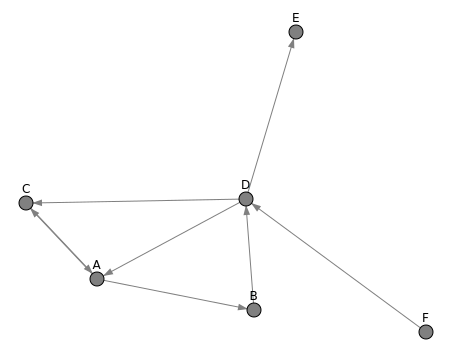

In [4]:
image = skn.visualization.graphs.visualize_graph(adjacency=graph.adjacency, names=graph.names, name_position='above')
SVG(image)

## First Attempt: Simplified Approach

To gain some intuition, let's first work through a basic version of the algorithm. We will create an iterative procedure, that will function as follows:
* initialize all nodes in the graph to have the same rank value $= 1/(\text{number of nodes in the graph})$
* on each iteration, transfer the rank value from the source node to destination node in proportion to the number of out-edges from the source node

To express how rank value $P_r$ is transferred mathematically:

$P_r(p_i) = \sum_{\text{edges}_{ji}} \frac{P_r(p_j)}{O_{j}}$

where $p$ represents the pages/nodes in our graph, $i$ indexes over the destination nodes, $j$ indexes over the source nodes, and $O$ is a count of all the outlinks from the $j^{th}$ source node. We compute the above ratio and sum over all existing edges that run from $j$ to $i$.

### Problems with the Simplified Approach

Nodes E and F represent problems for the simplified algorithm presented above. Node E is a sink, where it only has an input edge directed towards it. As a consequence, rank value will tend to to be lost at this node over successive iterations in the algorithm. For node F, which is a source node, on the first iteration the assigned rank value for F will be granted to node D, and F will be left with a value of 0.

This doesn't seem to be sensible treatment for source or sink nodes. Let's make a somewhat more sophisticated algorithm, to handle nodes like E & F!

## A More Sophisticated Approach: Introducing the Damping Factor

We can make a more realistic model by introducing a *damping factor* $d$, that is the probability a user will follow a link on page $p_j$ to page $p_i$. Conversely, $1-d$ is termed the *fly-out probability*, which is the chance a user will select a new page at random (i.e. will not follow an edge in the graph). With the inclusion of $d$, it is now possible to move past node E after landing on it, and it is possible to arrive back at F after leaving it.

Mathematically, we can include the damping factor in the following way:

$P_r(p_i) = d\sum_{\text{edges}_{ji}} \frac{P_r(p_j)}{O_{j}} + \frac{1-d}{N_p}$

where $N_p$ is the total number of pages/nodes in the graph. 

## The Algorithm

We can now write out the algorithm we will follow here for each iteration $t=0,1,2,...$:

1. Initialize the rank values for all pages $P_r(p_i; t)$ in the graph at $t=0$ with: $P_r(p_i; 0)=\frac{1}{N_p}$
2. For $t=1,2,3,...$ update the rank values with $P_r(p_i;t+1) = d\sum_{\text{edges}_{ji}} \frac{P_r(p_j;t)}{O_{j}} + \frac{1-d}{N_p}$

Let's write things more compactly, by writing a matrix equation using the following objects:

${\bf P_r(t)} = \begin{bmatrix} P_r(p_0;t) \\ P_r(p_1;t) \\ \vdots \\ P_r(p_{N_p};t) \end{bmatrix}$

${\bf D} = \begin{bmatrix} 1/D_{0,0} && 0 && \cdots && 0 \\ 
                           0 && 1/D_{1,1} &&        && \vdots \\
                            \vdots    &&           && \ddots &&        \\
                           0 && \cdots  &&        && 1/D_{N_p,N_p} \end{bmatrix}$

${\bf O} = \begin{bmatrix} O_{0,0} && O_{0,1} && \cdots && O_{0,N_p} \\ 
                           O_{1,0} && O_{1,1} &&        && \vdots \\
                           \vdots    &&           && \ddots &&        \\
                           O_{N_p,0} && \cdots  &&        && O_{N_p,N_p} \end{bmatrix}$

${\bf \hat{O}} = {\bf OD}$

Here we have: 
* ${\bf P_r(t)}$ is a column vector containing all the page ranks at step $t$
* ${\bf D}$ is a square diagonal matrix, where each element along the diagonal is either the inverse of the out-degree of node $i$, or $0.0$ if there are no outgoing edges
* ${\bf O}$ is the square adacency matrix for the graph
* ${\bf \hat{O}}$ is a modified form of the adacency matrix, where each element $\hat{O}_{i,j}$ is the ratio of edges from $j \rightarrow i$ divided by the total out-degree of node $j$
* each column in ${\bf \hat{O}}$ is normalized to sum to 1.0

Now we can rewrite the PageRank update at $t+1$ as:

${\bf P_r(t+1)} = d{\bf \hat{O}P_r(t)} + \frac{1-d}{N_p}{\bf 1}$

where the column vector ${\bf 1}$ consists of $N_p$ elements all set to 1.0.

We can continue updating until convergence is reached as set by $\epsilon$:

$|{\bf P_r(t+1)} - {\bf P_r(t)}| < \epsilon$

## Implementation

Let's now proceed to implement the algorithm covered above:

In [5]:
class Graph(object):

    def __init__(self, edges: List[Tuple]) -> None:
        # initialize objects
        nodes = set()
        indegrees = {}
        outdegrees = {}
        # determine the unique set of nodes in the graph, and count number of outbound edges per source node
        for edge in edges:
            nodes.update(list(edge))
            src, dst = edge
            try:
                outdegrees[src] += 1
            except:
                outdegrees[src] = 1
            try:
                indegrees[dst] += 1
            except:
                indegrees[dst] = 1
        nodes = list(nodes)
        nodes.sort()
        # store graph data
        self.edges = edges
        self.nodes = nodes
        self.number_nodes = len(nodes)
        self.number_edges = len(edges)
        self.indegrees = indegrees
        self.outdegrees = outdegrees

    def _build_adjacency_matrix(self) -> np.array:
        # work out adjacency matrix
        O = np.zeros((self.number_nodes,self.number_nodes))
        for edge in self.edges:
            src, dst = edge
            O[self.nodes.index(dst),self.nodes.index(src)] += 1
        return O

    def _build_outdegree_matrix(self) -> np.array:
        D = np.zeros((self.number_nodes,self.number_nodes))
        for node in self.nodes:
            try:
                D[self.nodes.index(node),self.nodes.index(node)] = 1/self.outdegrees[node]
            except:
                D[self.nodes.index(node),self.nodes.index(node)] = 0
        return D
    
    def get_modified_adjacency_matrix(self) -> np.array:
        return np.matmul(self._build_adjacency_matrix(),self._build_outdegree_matrix())
    
    def get_edges(self) -> List[Tuple]:
        return self.edges

    def get_nodes(self) -> List:
        return self.nodes

    def get_number_edges(self) -> int:
        return self.number_edges

    def get_number_nodes(self) -> int:
        return self.number_nodes

    def get_indegrees(self) -> dict:
        return self.indegrees
    
    def get_outdegrees(self) -> dict:
        return self.outdegrees

In [6]:
class PageRank(object):

    def __init__(self, damping_factor: float=0.85, epsilon: float=1e-8) -> None:
        self.damping_factor = damping_factor
        self.epsilon = epsilon
    
    def _initalize_pagerank(self, graph: Graph) -> np.array:
        return (1/graph.get_number_nodes())*np.ones((graph.get_number_nodes(),1))
        
    def _identity_vector(self, graph: Graph) -> np.array:
        return np.ones((graph.get_number_nodes(),1))

    def _step(self, P1: np.array, I: np.array, graph: Graph) -> np.array:
        P2 = (
            self.damping_factor*np.matmul(graph.get_modified_adjacency_matrix(),P1) 
            + (1 - self.damping_factor)*I/graph.get_number_nodes()
        )
        return(P2/np.sum(P2))
    
    def evaluate(self, graph: Graph) -> dict:
        # obtain nodes from graph
        nodes = graph.get_nodes()
        # setup initial pagerank steps
        P1 = self._initalize_pagerank(graph)
        I  = self._identity_vector(graph)
        P2 = self._step(P1, I, graph)
        # step through the algorithm, updating our pageranks 
        while(np.linalg.norm(P1 - P2) >= self.epsilon):
            P1 = P2
            P2 = self._step(P1, I, graph)
        # package results and return
        pageranks = {}
        for node, rank in zip(nodes,P2.flatten()):
            pageranks[node] = rank
        return pageranks

In [7]:
# create a graph object
graph = Graph(edges)

In [8]:
# create a pagerank object
pr = PageRank()

In [9]:
# compute pageranks
ranks = pr.evaluate(graph)

In [10]:
ranks

{'A': 0.29526336887933935,
 'B': 0.16277503210453523,
 'C': 0.22454693557427846,
 'D': 0.20155998078146667,
 'E': 0.08881329306506174,
 'F': 0.027041389595318478}

These results seem sensible: the most interconnected nodes A, C, & D have the largest rank values. At the same time F, with no inbound links, has by far the lowest rank. 

## Verify Results

Let's now double check our results, by comparing with the built-in PageRank from scikit-network.  

In [ ]:
#from sknetwork.ranking import PageRank

In [ ]:
#graph = skn.data.from_edge_list(edges, directed=True)
#adjacency = graph.adjacency

In [ ]:
#pagerank = PageRank()
#scores = pagerank.fit_predict(adjacency)

In [ ]:
#scores

For the most part, the rankings here look very similar to those obtained with our custom implementation. Nodes A, C, and D are among the highest ranked in the graph, which makes sense as they have a large degree. The biggest difference between the two sets of results is the page rank for node E, where this value is given more weight through the scikit-network model. 

As mentioned previously, Node E is a sink, or *dangling node*. The classic PageRank algorithm, presented here, has a hard time dealing with dangling nodes correctly. This fact is highlighted by the discrepancy between the two sets of values. Further alterations to the PageRank algorithm are required to handle nodes like E. 